In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9144163064267553881
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1749391771
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12311138931729875072
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
path = './dataset/mnist.npz'

import numpy as np

with np.load(path, allow_pickle=True) as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']
    
print(len(x_train))
print(len(y_train))

print(len(x_test))
print(len(y_test))

60000
60000
10000
10000


In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from random import *

In [6]:
x_train = x_train/255.0
x_test = x_test/255.0

In [7]:
print(x_train[0])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

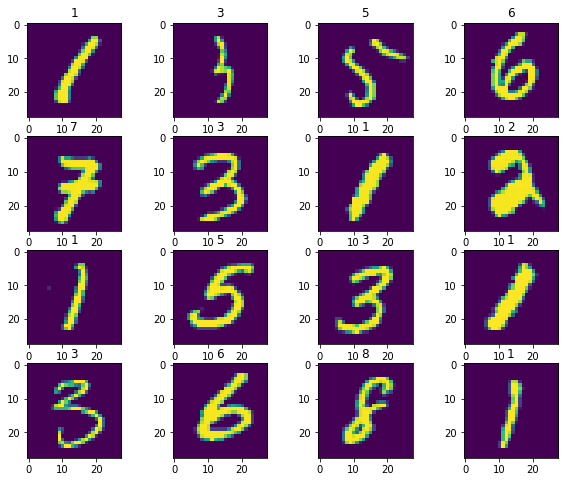

In [8]:
fig = plt.figure(figsize=(10,8))
columns = 4
rows = 4

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    r = randint(0, 59999)
    plt.imshow(x_train[r])
    plt.title(y_train[r])
    
plt.show()

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [10]:
def setup_gpus():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            tf.config.experimental.set_visible_devices(gpus[0],'GPU')
            tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1500)])
        except RuntimeError as e:
            print(e)
            
setup_gpus()

In [47]:

model = tf.keras.Sequential()

model.add(Conv2D(16,(7,7), name = "conv2d_0", padding='same',input_shape=(28,28,1)))
model.add(Activation('relu'))

model.add(Conv2D(32,(5,5), name = "conv2d_1",padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))



model.add(Conv2D(32,(3,3), name = "conv2d_3",padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2,2)))



model.add(Flatten(name = "flatten"))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))


model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_0 (Conv2D)           (None, 28, 28, 16)        800       
                                                                 
 activation_20 (Activation)  (None, 28, 28, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        12832     
                                                                 
 activation_21 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 batch_normalization_12 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                  

In [48]:
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('../model/without_one_hot.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience = 2,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.3,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [earlystop,checkpoint,reduce_lr]

model.compile(loss = "sparse_categorical_crossentropy", optimizer = Adam(learning_rate=0.005), metrics = ["accuracy"])

In [49]:
checkpoint = ModelCheckpoint('./model/without_one_hot.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.2,
                              patience=1,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [earlystop,checkpoint,reduce_lr]

model.compile(loss = "sparse_categorical_crossentropy", optimizer = Adam(learning_rate=0.005), metrics = ["accuracy"])

In [50]:
history = model.fit(x_train, y_train, epochs=14, validation_split = 0.30, batch_size = 20, callbacks = callbacks)

Epoch 1/14
2089/2100 [============================>.] - ETA: 0s - loss: 0.1452 - accuracy: 0.9556
Epoch 1: val_loss improved from inf to 0.12881, saving model to ./model\without_one_hot.h5
2100/2100 [==============================] - 13s 6ms/step - loss: 0.1448 - accuracy: 0.9557 - val_loss: 0.1288 - val_accuracy: 0.9710 - lr: 0.0050
Epoch 2/14
2093/2100 [============================>.] - ETA: 0s - loss: 0.0761 - accuracy: 0.9769
Epoch 2: val_loss improved from 0.12881 to 0.05300, saving model to ./model\without_one_hot.h5
2100/2100 [==============================] - 12s 6ms/step - loss: 0.0760 - accuracy: 0.9770 - val_loss: 0.0530 - val_accuracy: 0.9847 - lr: 0.0050
Epoch 3/14
2100/2100 [==============================] - ETA: 0s - loss: 0.0581 - accuracy: 0.9818
Epoch 3: val_loss improved from 0.05300 to 0.04697, saving model to ./model\without_one_hot.h5
2100/2100 [==============================] - 12s 6ms/step - loss: 0.0581 - accuracy: 0.9818 - val_loss: 0.0470 - val_accuracy: 0.98

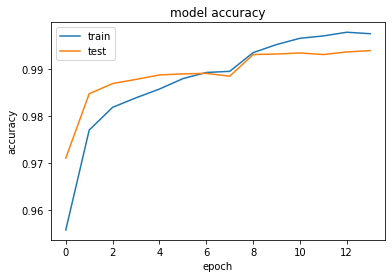

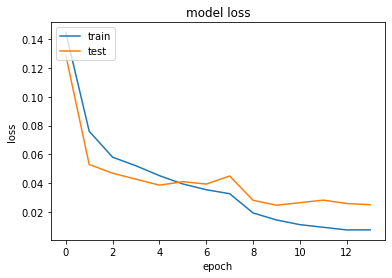

In [51]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
model = tf.keras.models.load_model("./model/without_one_hot.h5")

In [54]:
loss, acc = model.evaluate(x_test, y_test , verbose=2)

313/313 - 1s - loss: 0.0145 - accuracy: 0.9955 - 1s/epoch - 4ms/step


In [55]:
yp = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


   Actual :  4
Predicted :  [0.000000 0.000000 0.000000 0.000000 0.999997 0.000000 0.000000 0.000000
 0.000000 0.000003]


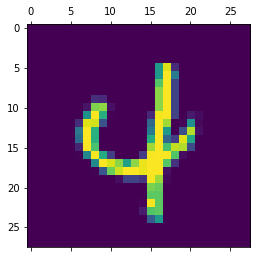

In [56]:
ind = 1300

plt.matshow(x_test[ind])
print("   Actual : ",y_test[ind])
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
print("Predicted : ",yp[ind])
# print(yp[5].shape)

# labels

In [57]:
y_pred_labels = []
for i in yp:
    y_pred_labels.append(np.argmax(i))

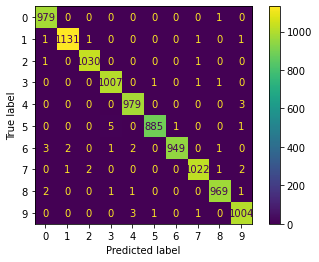

313/313 - 1s - loss: 0.0145 - accuracy: 0.9955 - 896ms/epoch - 3ms/step


In [58]:
import pandas as pd
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, y_pred_labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


loss, acc = model.evaluate(x_test, y_test , verbose=2)
# print(labels)

In [59]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred_labels)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.992901 0.997354 0.997096 0.993097 0.993909 0.997745 0.998947 0.996101
 0.995889 0.992095]
recall: [0.998980 0.996476 0.998062 0.997030 0.996945 0.992152 0.990605 0.994163
 0.994867 0.995045]
fscore: [0.995931 0.996915 0.997579 0.995059 0.995425 0.994941 0.994759 0.995131
 0.995378 0.993568]
support: [ 980 1135 1032 1010  982  892  958 1028  974 1009]
